In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


# Intro into RFM Framework

RFM framework is a method used to determine customer value by looking at the following three dimensions:
* Recency: when is the last time the user takes an action (e.g., login, place an order)? 
* Frequency: how many times does the user take this action?
* Monetary value: what is the sum of monetary value from this user throughout his/her lifetime?

When used properly, RFM becomes a powerful tool to identify the most valuable customer (MVC) of a business. Based on the output from this model, we are able to develop customized CRM strategies for different customer segments. With this post, I want to share the Kaggle notebook from an RFM segmentation analysis plus some tips that I found useful in the application of the model output.

In [2]:
# Load the dataset and have a peek into first rows
data = pd.read_csv("/kaggle/input/ecommerce-data/data.csv")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Check the basic info of the dataset: size, variables, data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# Note that we have some missing values in column "Description" and "CustomerID".
# Since our goal is to create a customer segmentation using the RFM framework, we need 
# drop rows with missing customer ID and description.
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [5]:
# Convert column "InvoiceDate" to datetime
from datetime import datetime
data["InvoiceDate"] = data["InvoiceDate"].apply(lambda x: x.split(' ')[0])
data["InvoiceDate"].head()

0    12/1/2010
1    12/1/2010
2    12/1/2010
3    12/1/2010
4    12/1/2010
Name: InvoiceDate, dtype: object

In [6]:
data["InvoiceDate"] = data["InvoiceDate"].apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))

In [7]:
# Check the dataset info after conversion
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [8]:
# Create a new variable OrderValue = Quanity * UnitPrice
data["OrderValue"] = data["Quantity"] * data["UnitPrice"]
data[["Quantity", "UnitPrice", "OrderValue"]].head()

,Quantity,UnitPrice,OrderValue
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


In [9]:
# Aggregate at customer level
customer_data = pd.DataFrame(data.pivot_table(index="CustomerID", 
                                              values=["InvoiceDate", "OrderValue"], 
                                              aggfunc={"InvoiceDate": [min, max, pd.Series.nunique], "OrderValue": sum}))
customer_data.head()

InvoiceDate                    OrderValue
                   max        min nunique        sum
CustomerID                                          
12346.0     2011-01-18 2011-01-18       1       0.00
12347.0     2011-12-07 2010-12-07       7    4310.00
12348.0     2011-09-25 2010-12-16       4    1797.24
12349.0     2011-11-21 2011-11-21       1    1757.55
12350.0     2011-02-02 2011-02-02       1     334.40

In [10]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4372 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   (InvoiceDate, max)      4372 non-null   datetime64[ns]
 1   (InvoiceDate, min)      4372 non-null   datetime64[ns]
 2   (InvoiceDate, nunique)  4372 non-null   int64         
 3   (OrderValue, sum)       4372 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 170.8 KB


In [11]:
# Rename columns
customer_data.columns = ["LastInvoiceDate", "FirstInvoiceDate", "Frequency", "MonetaryValue"]
customer_data.head()

,LastInvoiceDate,FirstInvoiceDate,Frequency,MonetaryValue
CustomerID,,,,
12346.0,2011-01-18,2011-01-18,1,0.00
12347.0,2011-12-07,2010-12-07,7,4310.00
12348.0,2011-09-25,2010-12-16,4,1797.24
12349.0,2011-11-21,2011-11-21,1,1757.55
12350.0,2011-02-02,2011-02-02,1,334.40


Text(0.5, 1.0, 'Monthly Customer Intakes')

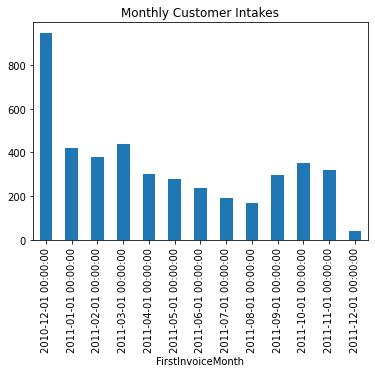

In [12]:
import matplotlib.pyplot as plt
# Create column "FirstInvoceMonth" to look at customer intake
customer_data["FirstInvoiceMonth"] = customer_data["FirstInvoiceDate"].apply(lambda x: x.replace(day=1))
customer_data.groupby(["FirstInvoiceMonth"]).count()["FirstInvoiceDate"].plot(kind="bar")
plt.title("Monthly Customer Intakes")

In [13]:
# Calculate recency, relative recency and relative frequency
# Take the maximum invoice date as today
today = customer_data["LastInvoiceDate"].max()
today

Timestamp('2011-12-09 00:00:00')

<AxesSubplot:>

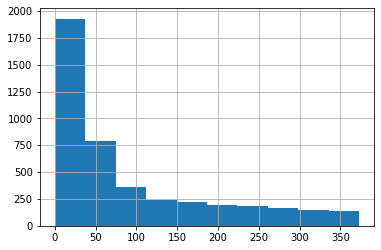

In [14]:
# Calculate recency: the interval (days) between the last transation day and today
customer_data["Recency"] = (today - customer_data["LastInvoiceDate"]) / np.timedelta64(1, 'D')
customer_data["Recency"].hist()

<AxesSubplot:>

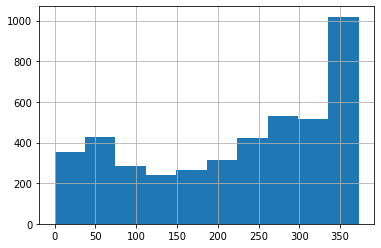

In [15]:
# Calculate customer lifetime: the interval (days) between the first transation day and today
customer_data["Lifetime"] = (today - customer_data["FirstInvoiceDate"]) / np.timedelta64(1, 'D')
customer_data["Lifetime"].hist()

In [16]:
customer_data["Lifetime"].describe()

count    4372.000000
mean      225.304209
std       118.384168
min         0.000000
25%       115.000000
50%       253.000000
75%       331.000000
max       373.000000
Name: Lifetime, dtype: float64

<AxesSubplot:>

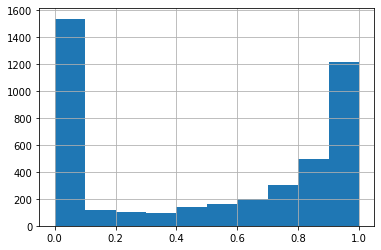

In [17]:
# Calculate the relative recency: recency / customer lifetime
# Note: this is to normalise the fact that newer customers have lower lifetime and thus lower recency
# by nature.
customer_data["RelRecency"] = 1 - customer_data["Recency"] / customer_data["Lifetime"]
customer_data["RelRecency"].hist()

In [18]:
customer_data["Recency"].describe()

count    4372.000000
mean       91.581199
std       100.772139
min         0.000000
25%        16.000000
50%        50.000000
75%       143.000000
max       373.000000
Name: Recency, dtype: float64

In [19]:
customer_data["RelRecency"].describe()

count    4371.000000
mean        0.499609
std         0.414152
min         0.000000
25%         0.000000
50%         0.614458
75%         0.918199
max         1.000000
Name: RelRecency, dtype: float64

In [20]:
sum(customer_data["RelRecency"]==0) / len(customer_data)
# This shows that 31% customers only had one transactions.

0.31564501372369624

In [21]:
# Calculate the relative frequency: frequency / customer lifetime
# Note: this is to normalise the fact that newer customers have lower lifetime and thus lower frequency
# by nature.
customer_data["RelFrequency"] = customer_data["Frequency"] / customer_data["Lifetime"]
customer_data["RelFrequency"].apply(lambda x: np.isinf(x)).value_counts()

False    4371
True        1
Name: RelFrequency, dtype: int64

In [22]:
# Found a record with inifinity value, we need to remove it
customer_data[customer_data["RelFrequency"].apply(lambda x: np.isinf(x))]

,LastInvoiceDate,FirstInvoiceDate,Frequency,MonetaryValue,FirstInvoiceMonth,Recency,Lifetime,RelRecency,RelFrequency
CustomerID,,,,,,,,,
12713.0,2011-12-09,2011-12-09,1,848.55,2011-12-01,0.0,0.0,NaN,inf


<AxesSubplot:>

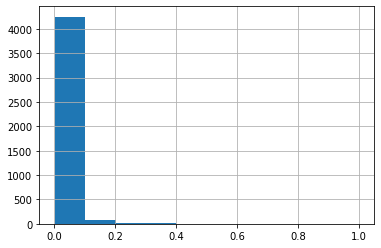

In [23]:
customer_data = customer_data[customer_data["RelFrequency"].apply(lambda x: np.isinf(x))==False]
customer_data["RelFrequency"].hist()

In [24]:
customer_data["RelFrequency"].describe()

count    4371.000000
mean        0.026130
std         0.046294
min         0.002681
25%         0.008152
50%         0.015707
75%         0.028846
max         1.000000
Name: RelFrequency, dtype: float64

In [25]:
# Calculate the relative monetary value: monetary value / customer lifetime
# Note: this is to normalise the fact that newer customers have lower lifetime and thus lower frequency
# by nature.
customer_data["MonetaryValue"].describe()

count      4371.000000
mean       1898.699900
std        8220.270169
min       -4287.630000
25%         293.275000
50%         647.740000
75%        1611.860000
max      279489.020000
Name: MonetaryValue, dtype: float64

<AxesSubplot:>

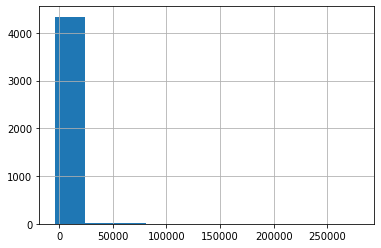

In [26]:
customer_data["MonetaryValue"].hist()
# There are some outliers in terms of monetary value.

In [27]:
np.percentile(customer_data["MonetaryValue"], 99)
# The 99.5% percentile of monetary value is 33.4K, i.e., 0.5% * 4K = 20 customers have value higher than 33.4K.
# We should exclude these outliers from our analysis.

17231.393000000095

In [28]:
customer_data = customer_data[customer_data["MonetaryValue"]<=np.percentile(customer_data["MonetaryValue"], 99)]

In [29]:
len(customer_data)

4327

In [30]:
len(customer_data[customer_data["MonetaryValue"]<0])
# 43 customers have negative transation value because of the returns.

43

In [31]:
customer_data[customer_data["MonetaryValue"]<0].head()

,LastInvoiceDate,FirstInvoiceDate,Frequency,MonetaryValue,FirstInvoiceMonth,Recency,Lifetime,RelRecency,RelFrequency
CustomerID,,,,,,,,,
12454.0,2011-10-17,2011-10-14,2,-5.684342e-14,2011-10-01,53.0,56.0,0.053571,0.035714
12503.0,2011-01-06,2011-01-06,1,-1.126000e+03,2011-01-01,337.0,337.0,0.000000,0.002967
12505.0,2011-02-11,2011-02-11,1,-4.500000e+00,2011-02-01,301.0,301.0,0.000000,0.003322
12605.0,2010-12-09,2010-12-09,1,-7.500000e+00,2010-12-01,365.0,365.0,0.000000,0.002740
12666.0,2010-12-15,2010-12-15,1,-2.274400e+02,2010-12-01,359.0,359.0,0.000000,0.002786


In [32]:
data[data["CustomerID"]==12454]
# Some customers have a negative sum of order value. This is because they have returns.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,OrderValue
398626,571255,82494L,WOODEN FRAME ANTIQUE WHITE,72,2011-10-14,2.55,12454.0,Spain,183.60
398627,571255,82483,WOOD 2 DRAWER CABINET WHITE FINISH,32,2011-10-14,5.95,12454.0,Spain,190.40
398628,571255,82486,3 DRAWER ANTIQUE WHITE WOOD CABINET,12,2011-10-14,8.15,12454.0,Spain,97.80
398629,571255,22423,REGENCY CAKESTAND 3 TIER,32,2011-10-14,10.95,12454.0,Spain,350.40
398630,571255,22173,METAL 4 HOOK HANGER FRENCH CHATEAU,32,2011-10-14,2.75,12454.0,Spain,88.00
398631,571255,82482,WOODEN PICTURE FRAME WHITE FINISH,72,2011-10-14,2.55,12454.0,Spain,183.60
398632,571255,23064,CINDERELLA CHANDELIER,10,2011-10-14,41.75,12454.0,Spain,417.50
398633,571255,23055,IVORY CHANDELIER T-LIGHT HOLDER,48,2011-10-14,5.39,12454.0,Spain,258.72
398634,571255,23056,FLOWERS CHANDELIER T-LIGHT HOLDER,48,2011-10-14,5.39,12454.0,Spain,258.72
398635,571255,23057,BEADED CHANDELIER T-LIGHT HOLDER,48,2011-10-14,4.15,12454.0,Spain,199.20


<AxesSubplot:>

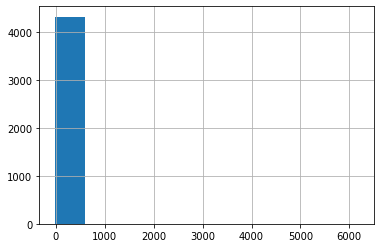

In [33]:
customer_data["RelMonetaryValue"] = customer_data["MonetaryValue"] / customer_data["Lifetime"]
customer_data["RelMonetaryValue"].hist()

In [34]:
customer_data["RelMonetaryValue"].describe()

count    4327.000000
mean        9.972495
std        99.884916
min       -29.775208
25%         1.682288
50%         4.148408
75%         9.238084
max      6196.850000
Name: RelMonetaryValue, dtype: float64

# Create RFM buckets using absolute values

In [35]:
# Create RFM buckets using absolute values
# For this analysis, we take the medians and 75% quartiles of relative recency, relative frequency and relative monetary value and use them for
# 4 bins for each variable. We label those bins as 1, 2, 3 and 4 and use them as the scores for R, F and M respectively.
# We then create 
# By doing so we end up with 10 clusters ()

In [36]:
customer_data['RecencyScore'] = pd.cut(customer_data["Recency"], 
                                       bins=[-1, 
                                             np.percentile(customer_data["Recency"], 25), 
                                             np.percentile(customer_data["Recency"], 50), 
                                             np.percentile(customer_data["Recency"], 75), 
                                             customer_data["Recency"].max()], 
                                       labels=[4, 3, 2, 1]).astype("int")
customer_data["RecencyScore"].value_counts()

4    1131
1    1077
2    1071
3    1048
Name: RecencyScore, dtype: int64

In [37]:
customer_data["FrequencyScore"] = pd.cut(customer_data["Frequency"], 
                                       bins=[-1, 
                                             np.percentile(customer_data["Frequency"], 25), 
                                             np.percentile(customer_data["Frequency"], 50), 
                                             np.percentile(customer_data["Frequency"], 75), 
                                             customer_data["Frequency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
customer_data["FrequencyScore"].value_counts()

1    1380
3    1164
4     926
2     857
Name: FrequencyScore, dtype: int64

In [38]:
customer_data["MonetaryScore"] = pd.cut(customer_data["MonetaryValue"], 
                                       bins=[customer_data["MonetaryValue"].min()-1, 
                                             np.percentile(customer_data["MonetaryValue"], 25),
                                             np.percentile(customer_data["MonetaryValue"], 50), 
                                             np.percentile(customer_data["MonetaryValue"], 75), 
                                             customer_data["MonetaryValue"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
customer_data["MonetaryScore"].value_counts()

4    1082
1    1082
2    1082
3    1081
Name: MonetaryScore, dtype: int64

In [39]:
customer_data["RFM"] = customer_data["RecencyScore"] + customer_data["FrequencyScore"] + customer_data["MonetaryScore"]
customer_data["RFM"].value_counts()

5     493
6     467
4     460
12    458
9     450
7     422
3     417
10    415
8     403
11    342
Name: RFM, dtype: int64

In [40]:
rfm_abs = pd.DataFrame(customer_data.pivot_table(index=["RFM"], 
                                    values=["Recency", "Frequency", "MonetaryValue", "Lifetime"], 
                                    aggfunc={"Recency": [np.min, np.median, np.max], 
                                             "Frequency": [np.min, np.median, np.max], 
                                             "MonetaryValue": [np.min, np.median, np.max], 
                                             "Lifetime": [np.min, np.median, np.max, "count"]}))
rfm_abs

Frequency             Lifetime                     MonetaryValue           \
         amax amin median     amax   amin count median          amax     amin   
RFM                                                                             
3           1    1      1    373.0  145.0   417  269.0        290.36 -1192.20   
4           2    1      1    373.0   51.0   460  200.5        628.28 -4287.63   
5           4    1      1    373.0   18.0   493   93.0       1384.25  -141.48   
6           7    1      2    373.0    1.0   467  116.0       3096.00     0.00   
7           6    1      2    373.0    1.0   422  198.0       9861.38 -1165.30   
8           8    1      3    373.0    3.0   403  248.0       7829.89   102.45   
9          12    1      4    373.0    2.0   450  255.5      12393.70   292.00   
10         35    2      5    373.0   10.0   415  274.0      11581.80   306.72   
11         22    3      7    373.0   24.0   342  312.0      14520.08   641.55   
12         89    6     11    373.0   44.0   458  358.0      17078.45  1568.39   

               Recency                
        median    amax   amin median  
RFM                                   
3     150.3000   373.0  145.0  269.0  
4     257.5400   373.0   51.0  185.0  
5     311.6900   372.0   18.0   84.0  
6     422.8800   372.0    1.0   65.0  
7     573.3555   366.0    0.0   53.0  
8     759.1700   330.0    1.0   50.0  
9    1056.4900   267.0    0.0   32.0  
10   1393.7900   143.0    0.0   21.0  
11   2265.2500    50.0    0.0   18.0  
12   3717.7450    17.0    0.0    7.0

As we can see, the groups have very different median days of lifetime. This suggests potential bias associated with customer sign up date.

# Create RFM buckets using relative values

In [41]:
# Create RFM buckets using relative values
# For this analysis, we take the medians and 75% quartiles of relative recency, relative frequency and relative monetary value and use them for
# 4 bins for each variable. We label those bins as 1, 2, 3 and 4 and use them as the scores for R, F and M respectively.
# We then create 
# By doing so we end up with 10 clusters ()
customer_data["RecencyScore"] = pd.cut(customer_data["RelRecency"], 
                                       bins=[-1, 
                                             np.percentile(customer_data["RelRecency"], 25), 
                                             np.percentile(customer_data["RelRecency"], 50), 
                                             np.percentile(customer_data["RelRecency"], 75), 
                                             customer_data["RelRecency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
customer_data["RecencyScore"].value_counts()

1    1380
4    1082
3    1081
2     784
Name: RecencyScore, dtype: int64

In [42]:
customer_data["FrequencyScore"] = pd.cut(customer_data["RelFrequency"], 
                                       bins=[-1, 
                                             np.percentile(customer_data["RelFrequency"], 25), 
                                             np.percentile(customer_data["RelFrequency"], 50), 
                                             np.percentile(customer_data["RelFrequency"], 75), 
                                             customer_data["RelFrequency"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
customer_data["FrequencyScore"].value_counts()

1    1091
3    1086
4    1077
2    1073
Name: FrequencyScore, dtype: int64

In [43]:
customer_data["MonetaryScore"] = pd.cut(customer_data["RelMonetaryValue"], 
                                       bins=[customer_data["RelMonetaryValue"].min()-1, 
                                             np.percentile(customer_data["RelMonetaryValue"], 25),
                                             np.percentile(customer_data["RelMonetaryValue"], 50), 
                                             np.percentile(customer_data["RelMonetaryValue"], 75), 
                                             customer_data["RelMonetaryValue"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")
customer_data["MonetaryScore"].value_counts()

4    1082
1    1082
2    1082
3    1081
Name: MonetaryScore, dtype: int64

In [44]:
customer_data.head()

,LastInvoiceDate,FirstInvoiceDate,Frequency,MonetaryValue,FirstInvoiceMonth,Recency,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,RecencyScore,FrequencyScore,MonetaryScore,RFM
CustomerID,,,,,,,,,,,,,,
12346.0,2011-01-18,2011-01-18,1,0.00,2011-01-01,325.0,325.0,0.000000,0.003077,0.000000,1,1,1,3
12347.0,2011-12-07,2010-12-07,7,4310.00,2010-12-01,2.0,367.0,0.994550,0.019074,11.743869,4,3,4,12
12348.0,2011-09-25,2010-12-16,4,1797.24,2010-12-01,75.0,358.0,0.790503,0.011173,5.020223,3,2,3,9
12349.0,2011-11-21,2011-11-21,1,1757.55,2011-11-01,18.0,18.0,0.000000,0.055556,97.641667,1,4,4,8
12350.0,2011-02-02,2011-02-02,1,334.40,2011-02-01,310.0,310.0,0.000000,0.003226,1.078710,1,1,1,4


In [45]:
customer_data["RFM"] = customer_data["RecencyScore"] + customer_data["FrequencyScore"] + customer_data["MonetaryScore"]
customer_data["RFM"].value_counts()

9     572
3     557
8     521
7     491
6     455
10    429
11    346
12    344
5     313
4     299
Name: RFM, dtype: int64

In [46]:
rfm_rel = pd.DataFrame(customer_data.pivot_table(index=["RFM"], 
                                    values=["Recency", "Frequency", "MonetaryValue", "Lifetime"], 
                                    aggfunc={"Recency": [np.min, np.median, np.max], 
                                             "Frequency": [np.min, np.median, np.max], 
                                             "MonetaryValue": [np.min, np.median, np.max], 
                                             "Lifetime": [np.min, np.median, np.max, "count"]}))
rfm_rel
# Note that the median lifetime is rather constant across clusters. This is a good news - our segmentation is not biased by the lifetime
# of the customers.

Frequency             Lifetime                     MonetaryValue  \
         amax amin median     amax   amin count median          amax   
RFM                                                                    
3           1    1      1    373.0  123.0   557  270.0        590.00   
4           3    1      1    373.0   65.0   299  260.0       1308.48   
5           5    1      2    373.0   38.0   313  256.0       2661.24   
6           7    1      2    373.0   14.0   455  235.0       4008.62   
7           8    1      2    373.0   14.0   491  212.0       5288.63   
8          10    1      3    373.0    7.0   521  236.0       9861.38   
9          11    1      4    373.0    1.0   572  198.5      12393.70   
10         35    2      5    373.0    9.0   429  249.0      11990.96   
11         22    2      7    373.0   10.0   346  241.5      13375.87   
12         89    2     13    373.0   17.0   344  333.5      17078.45   

                           Recency                
             amin   median    amax   amin median  
RFM                                               
3   -4.287630e+03   171.45   373.0  123.0  270.0  
4   -8.407600e+02   321.05   372.0   65.0  204.0  
5   -1.348000e+02   316.62   372.0   28.0  143.0  
6   -1.165300e+03   449.12   366.0    1.0   75.0  
7   -5.684342e-14   638.77   330.0    0.0   58.0  
8    2.664535e-14   819.29   306.0    1.0   38.0  
9    4.199000e+01   982.37   267.0    0.0   23.0  
10   1.370000e+02  1809.81   155.0    0.0   22.0  
11   2.141400e+02  2234.58   120.0    0.0    9.0  
12   3.964800e+02  4391.71    31.0    0.0    4.0

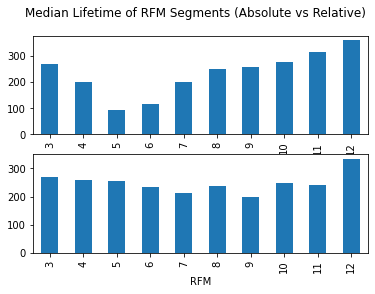

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle('Median Lifetime of RFM Segments (Absolute vs Relative)')
rfm_abs["Lifetime"]["median"].plot(ax=axes[0], kind="bar")
rfm_rel["Lifetime"]["median"].plot(ax=axes[1], kind="bar")
plt.show()

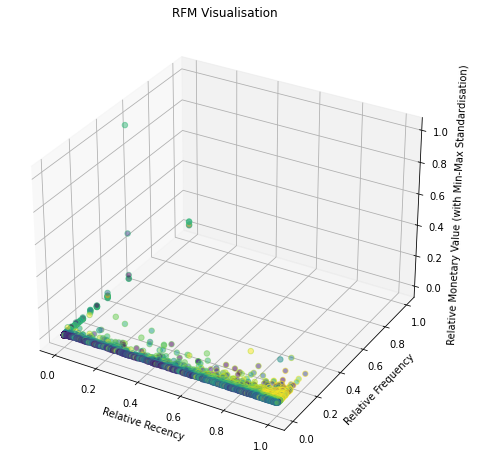

In [48]:
# Visualise segments using 3D plot
x = customer_data["RelRecency"]
y = customer_data["RelFrequency"]
z = (customer_data["RelMonetaryValue"] - customer_data["RelMonetaryValue"].min()) / customer_data["RelMonetaryValue"].max()
c = customer_data["RFM"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=x, ys=y, zs=z, c=c, s=30, alpha=0.5)
ax.set_title("RFM Visualisation")
ax.set_xlabel("Relative Recency")
ax.set_ylabel("Relative Frequency")
ax.set_zlabel("Relative Monetary Value (with Min-Max Standardisation)")
plt.show()

Text(0.5, 1.0, 'Relative Recency (x) vs Relative Monetary Value (y)')

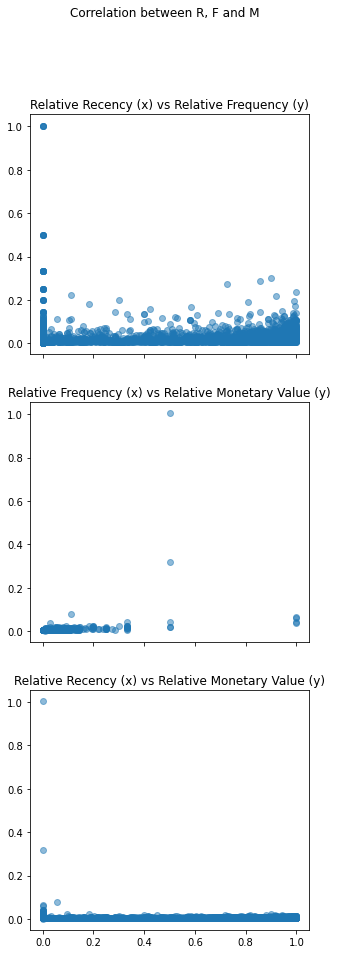

In [49]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(5, 15))
fig.suptitle('Correlation between R, F and M')

axs[0].scatter(x, y, alpha=0.5)
axs[0].set_title("Relative Recency (x) vs Relative Frequency (y)")

axs[1].scatter(y, z, alpha=0.5)
axs[1].set_title("Relative Frequency (x) vs Relative Monetary Value (y)")

axs[2].scatter(x, z, alpha=0.5)
axs[2].set_title("Relative Recency (x) vs Relative Monetary Value (y)")


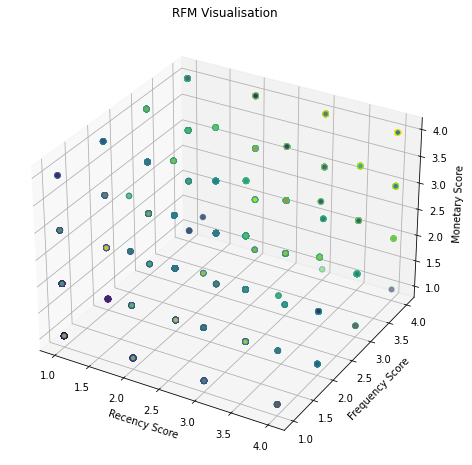

In [50]:
x = customer_data["RecencyScore"]
y = customer_data["FrequencyScore"]
z = customer_data["MonetaryScore"]
c = customer_data["RFM"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=x, ys=y, zs=z, c=c, s=30, alpha=0.5)
ax.set_title("RFM Visualisation")
ax.set_xlabel("Recency Score")
ax.set_ylabel("Frequency Score")
ax.set_zlabel("Monetary Score")
plt.show()

# Generate simple criteria for labelling

In [51]:
# From these statistics we can generate some heuristic business rules to simplify our segmentation.
# For example, RFM score 3 and 4 can be combined, because these two groups tend to have only one transaction.
# Create new columns with our learnings
customer_data.describe()

,Frequency,MonetaryValue,Recency,Lifetime,RelRecency,RelFrequency,RelMonetaryValue,RecencyScore,FrequencyScore,MonetaryScore,RFM
count,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000
mean,4.079039,1343.984997,92.408597,224.024728,0.494887,0.025330,9.972495,2.431015,2.496649,2.499884,7.427548
std,4.958752,1979.167289,100.902872,118.130616,0.413445,0.045113,99.884916,1.176236,1.119088,1.118267,2.775505
min,1.000000,-4287.630000,0.000000,1.000000,0.000000,0.002681,-29.775208,1.000000,1.000000,1.000000,3.000000
25%,1.000000,290.910000,17.000000,113.000000,0.000000,0.008130,1.682288,1.000000,1.000000,1.500000,5.000000
50%,2.000000,639.890000,50.000000,250.000000,0.603175,0.015528,4.148408,2.000000,2.000000,2.000000,8.000000
75%,5.000000,1550.490000,144.000000,329.000000,0.914954,0.028169,9.238084,3.500000,3.000000,3.500000,10.000000
max,89.000000,17078.450000,373.000000,373.000000,1.000000,1.000000,6196.850000,4.000000,4.000000,4.000000,12.000000


In [52]:
rfm_rel

Frequency             Lifetime                     MonetaryValue  \
         amax amin median     amax   amin count median          amax   
RFM                                                                    
3           1    1      1    373.0  123.0   557  270.0        590.00   
4           3    1      1    373.0   65.0   299  260.0       1308.48   
5           5    1      2    373.0   38.0   313  256.0       2661.24   
6           7    1      2    373.0   14.0   455  235.0       4008.62   
7           8    1      2    373.0   14.0   491  212.0       5288.63   
8          10    1      3    373.0    7.0   521  236.0       9861.38   
9          11    1      4    373.0    1.0   572  198.5      12393.70   
10         35    2      5    373.0    9.0   429  249.0      11990.96   
11         22    2      7    373.0   10.0   346  241.5      13375.87   
12         89    2     13    373.0   17.0   344  333.5      17078.45   

                           Recency                
             amin   median    amax   amin median  
RFM                                               
3   -4.287630e+03   171.45   373.0  123.0  270.0  
4   -8.407600e+02   321.05   372.0   65.0  204.0  
5   -1.348000e+02   316.62   372.0   28.0  143.0  
6   -1.165300e+03   449.12   366.0    1.0   75.0  
7   -5.684342e-14   638.77   330.0    0.0   58.0  
8    2.664535e-14   819.29   306.0    1.0   38.0  
9    4.199000e+01   982.37   267.0    0.0   23.0  
10   1.370000e+02  1809.81   155.0    0.0   22.0  
11   2.141400e+02  2234.58   120.0    0.0    9.0  
12   3.964800e+02  4391.71    31.0    0.0    4.0

In [53]:
customer_data["last_order_within_l60d"] = customer_data["Recency"]<60 # Had transactions in the last 60 days
customer_data["more_than_two_orders"] = customer_data["Frequency"]>2 # Logged in more than twice
customer_data["value_higher_than_2k"] = customer_data["MonetaryValue"]>2000 # Sum of value higher than 2K
customer_data.groupby(["last_order_within_l60d", "more_than_two_orders", "value_higher_than_2k"]).count()["Lifetime"]

last_order_within_l60d  more_than_two_orders  value_higher_than_2k
False                   False                 False                   1402
                                              True                      24
                        True                  False                    423
                                              True                     100
True                    False                 False                    794
                                              True                      17
                        True                  False                    876
                                              True                     691
Name: Lifetime, dtype: int64

In [54]:
conditions = [
    (customer_data["last_order_within_l60d"]==True)&(customer_data["more_than_two_orders"]==True)&(customer_data["value_higher_than_2k"]==True),
    (customer_data["last_order_within_l60d"]==True)&(customer_data["more_than_two_orders"]==True)&(customer_data["value_higher_than_2k"]==False),
    (customer_data["last_order_within_l60d"]==True)&(customer_data["more_than_two_orders"]==False),
    (customer_data["last_order_within_l60d"]==False)&(customer_data["more_than_two_orders"]==True),
    (customer_data["last_order_within_l60d"]==False)&(customer_data["more_than_two_orders"]==False)
]
mappings = ["01. high engagement & high value", 
            "02. high engagement & low value", 
            "03. recent and low frequency", 
            "04. old and high frequency", 
            "05. low engagement & low value"]
customer_data['FinalRFM'] = np.select(conditions, mappings, default="Others")
customer_data['FinalRFM'].value_counts()

05. low engagement & low value      1426
02. high engagement & low value      876
03. recent and low frequency         811
01. high engagement & high value     691
04. old and high frequency           523
Name: FinalRFM, dtype: int64

In [55]:
customer_data.pivot_table(index=["FinalRFM"], 
                          values=["Recency", "Frequency", "MonetaryValue", "Lifetime"], 
                          aggfunc={"Recency": [np.min, np.median, np.max], 
                                   "Frequency": [np.min, np.median, np.max], 
                                   "MonetaryValue": [np.min, np.median, np.max], 
                                   "Lifetime": [np.min, np.median, np.max, "count"]})

Frequency             Lifetime              \
                                      amax amin median     amax  amin count   
FinalRFM                                                                      
01. high engagement & high value        89    3     10    373.0  44.0   691   
02. high engagement & low value         35    3      4    373.0  10.0   876   
03. recent and low frequency             2    1      1    373.0   1.0   811   
04. old and high frequency              18    3      4    373.0  81.0   523   
05. low engagement & low value           2    1      1    373.0  60.0  1426   

                                        MonetaryValue                     \
                                 median          amax     amin    median   
FinalRFM                                                                   
01. high engagement & high value  337.0      17078.45  2000.86  3541.920   
02. high engagement & low value   266.0       1998.49 -1165.30  1041.755   
03. recent and low frequency       45.0      12393.70  -134.80   351.110   
04. old and high frequency        304.0      11581.80  -141.48   991.850   
05. low engagement & low value    238.0       9861.38 -4287.63   299.450   

                                 Recency               
                                    amax  amin median  
FinalRFM                                               
01. high engagement & high value    59.0   0.0   10.0  
02. high engagement & low value     59.0   0.0   18.0  
03. recent and low frequency        59.0   0.0   26.0  
04. old and high frequency         360.0  60.0  107.0  
05. low engagement & low value     373.0  60.0  191.0

# Bonus: calculate the percentage of new, active, inactive and return users in each month

In [56]:
# Calculate the number of new users, inactive users, return users and active users in each month
# Definition:
# New users: those who made their first purchase in the current month
# Active users: those who made purchases in the previous month and in the current month
# Inactive users: those who made purchases in previous months, but not in the current month
# Return users: those who made purchases before the previous month, not in the previous month and made purchases agian in the current month
data["InvoiceMonth"] = data["InvoiceDate"].apply(lambda x: x.replace(day=1))
data["InvoiceMonth"] = data["InvoiceMonth"].apply(lambda x: x.strftime("%Y-%m-%d"))
user_month_pivot = data.pivot_table(index=["CustomerID"], 
                                    columns=["InvoiceMonth"], 
                                    values=["InvoiceNo"], 
                                    aggfunc="count", 
                                    fill_value=0)
user_month_pivot.head()

InvoiceNo                                              \
InvoiceMonth 2010-12-01 2011-01-01 2011-02-01 2011-03-01 2011-04-01   
CustomerID                                                            
12346.0               0          2          0          0          0   
12347.0              31         29          0          0         24   
12348.0              17          6          0          0          5   
12349.0               0          0          0          0          0   
12350.0               0          0         17          0          0   

                                                                     \
InvoiceMonth 2011-05-01 2011-06-01 2011-07-01 2011-08-01 2011-09-01   
CustomerID                                                            
12346.0               0          0          0          0          0   
12347.0               0         18          0         22          0   
12348.0               0          0          0          0          3   
12349.0               0          0          0          0          0   
12350.0               0          0          0          0          0   

                                               
InvoiceMonth 2011-10-01 2011-11-01 2011-12-01  
CustomerID                                     
12346.0               0          0          0  
12347.0              47          0         11  
12348.0               0          0          0  
12349.0               0         73          0  
12350.0               0          0          0

In [57]:
# Replace count of invoices with 1
user_month_pivot = user_month_pivot.applymap(lambda x: 1 if x>0 else 0)
user_month_pivot.head()

InvoiceNo                                              \
InvoiceMonth 2010-12-01 2011-01-01 2011-02-01 2011-03-01 2011-04-01   
CustomerID                                                            
12346.0               0          1          0          0          0   
12347.0               1          1          0          0          1   
12348.0               1          1          0          0          1   
12349.0               0          0          0          0          0   
12350.0               0          0          1          0          0   

                                                                     \
InvoiceMonth 2011-05-01 2011-06-01 2011-07-01 2011-08-01 2011-09-01   
CustomerID                                                            
12346.0               0          0          0          0          0   
12347.0               0          1          0          1          0   
12348.0               0          0          0          0          1   
12349.0               0          0          0          0          0   
12350.0               0          0          0          0          0   

                                               
InvoiceMonth 2011-10-01 2011-11-01 2011-12-01  
CustomerID                                     
12346.0               0          0          0  
12347.0               1          0          1  
12348.0               0          0          0  
12349.0               0          1          0  
12350.0               0          0          0

In [58]:
# Get the number of columns
len((user_month_pivot).columns)

13

In [59]:
# Define functions to get user status
def user_status(data):
    status = []
    for i in range(13):
    # If the user has no purchase in the current month
        if data[i] == 0:
            # If the user has made purchases before
            if len(status) > 0:
                # If the user is unregistered in the previous month
                if status[i-1] == "unreg":
                # The the user is also unregistered this month
                    status.append("unreg")
                # Otherwise the user is an active user, i.e., he/she already registered
                else:
                    status.append("inactive")
            # Otherwise the user is not registered in the current month, i.e., he/she has never made any purchases
            else:
                status.append("unreg")
        else:
            # This is the first purchase of the user
            if len(status) == 0:
                status.append("new")
            else:
                if status[i-1] == "inactive":
                    status.append("return")
                elif status[i-1] == "unreg":
                    status.append("new")
                else:
                    status.append("active")
    return status

In [60]:
user_month_status = pd.DataFrame(user_month_pivot.apply(lambda x: pd.Series(user_status(x)), axis=1))
user_month_status.columns = user_month_pivot.columns
user_month_status.head()

InvoiceNo                                              \
InvoiceMonth 2010-12-01 2011-01-01 2011-02-01 2011-03-01 2011-04-01   
CustomerID                                                            
12346.0           unreg        new   inactive   inactive   inactive   
12347.0             new     active   inactive   inactive     return   
12348.0             new     active   inactive   inactive     return   
12349.0           unreg      unreg      unreg      unreg      unreg   
12350.0           unreg      unreg        new   inactive   inactive   

                                                                     \
InvoiceMonth 2011-05-01 2011-06-01 2011-07-01 2011-08-01 2011-09-01   
CustomerID                                                            
12346.0        inactive   inactive   inactive   inactive   inactive   
12347.0        inactive     return   inactive     return   inactive   
12348.0        inactive   inactive   inactive   inactive     return   
12349.0           unreg      unreg      unreg      unreg      unreg   
12350.0        inactive   inactive   inactive   inactive   inactive   

                                               
InvoiceMonth 2011-10-01 2011-11-01 2011-12-01  
CustomerID                                     
12346.0        inactive   inactive   inactive  
12347.0          return   inactive     return  
12348.0        inactive   inactive   inactive  
12349.0           unreg        new   inactive  
12350.0        inactive   inactive   inactive

In [61]:
month_status_pivot = pd.DataFrame(user_month_status.replace("unreg", np.NaN).apply(lambda x: pd.value_counts(x)))
month_status_pivot.head()

InvoiceNo                                              \
InvoiceMonth 2010-12-01 2011-01-01 2011-02-01 2011-03-01 2011-04-01   
active              NaN      362.0        299        345        346   
inactive            NaN      586.0        951       1169       1589   
new               948.0      421.0        380        440        299   
return              NaN        NaN        119        235        254   

                                                                     \
InvoiceMonth 2011-05-01 2011-06-01 2011-07-01 2011-08-01 2011-09-01   
active              399        464        415        433        465   
inactive           1688       1951       2200       2380       2356   
new                 279        235        191        167        298   
return              401        352        387        380        539   

                                               
InvoiceMonth 2011-10-01 2011-11-01 2011-12-01  
active              552        690        443  
inactive           2585       2620       3686  
new                 352        321         41  
return              521        700        202

In [62]:
month_status_pivot = month_status_pivot.fillna(0).T
month_status_pivot.reset_index(inplace=True)
month_status_pivot.set_index("InvoiceMonth", inplace=True)

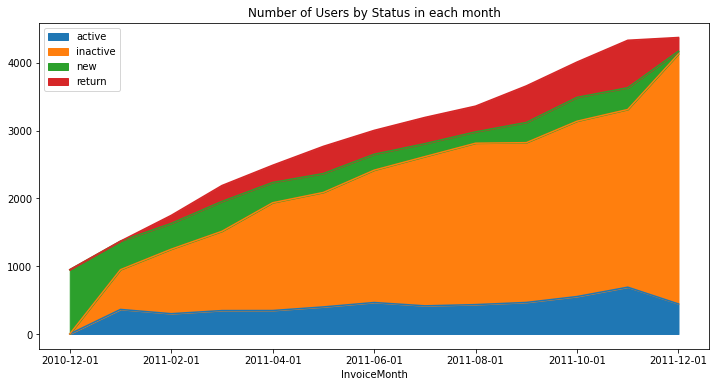

In [63]:
ax = month_status_pivot.plot.area(figsize = (12,6))
plt.title("Number of Users by Status in each month")
plt.show()